In [3]:
import sys
import os

folder_path = 'C://_Lib//refnx'  # Change this to your folder path
if folder_path not in sys.path:
    sys.path.insert(0, folder_path)

import scipy
import refnx
import numpy as np
from refnx.reflect import SLD, ReflectModel
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Objective, Transform, CurveFitter
import pandas as pd
import math

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, VBox, HBox, Output
from refnx.reflect import SLD, Structure, Slab
import ana_xrr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#Load dataset form Alex's notebook
def loadRefData(path, x_start=None, x_end=None):
    data = pd.read_csv(path)  # load text
    if x_start is None:
        x_start = 0
    if x_end is None:
        x_end = len(data)
    x = data['tth'][x_start:x_end]
    y = data['Normalized'][x_start:x_end].map(lambda x : x / data['Normalized'].max())
    # conv t-th to q using 0.72769 A wavelength
    x_new = x.map(lambda x: refnx.util.q(x / 2, 0.72769))
    compiled = (x_new, y)

    return ReflectDataset(compiled)


# Functions

In [5]:
# print(
#     f"refnx: {refnx.version.version}\n"
#     f"scipy: {scipy.version.version}\n"
#     f"numpy: {np.version.version}\n"
# )

import pandas as pd
import numpy as np

def round_to_sig_figs(x, sig_figs):
    if x == 0:
        return 0
    else:
        return np.round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)

def format_scientific(x):
    return "{:.4e}".format(x)
    
def generate_table(data):
    thk = np.round(data['thk'], 1)/10
    rough = np.round(data['rough'], 1)/10
    sld = np.round(data['sld'], 1)
    
    # Create a DataFrame from the provided data
    df = pd.DataFrame({
        'Layer': data['layers'],
        'Thickness (nm)': thk,
        'Roughness (nm)': rough,
        'SLD (10^-6 cm^-2)': sld
    })
    
    additional_params = pd.DataFrame({
        'Parameter': ['Chisq', 'Background', 'DQ - Resolution', 'Q Offset'],
        'Value': [format_scientific(round_to_sig_figs(data['chisq'], 4)), 
                  format_scientific(round_to_sig_figs(data['bkg'], 4)), 
                  format_scientific(round_to_sig_figs(data['dq - resolution'], 4)), 
                  format_scientific(round_to_sig_figs(data['q_offset'], 4))]
    })
    
    # Print the main table
    print("Layer Properties:")
    print(df.to_string(index=False))
    
    # Print additional parameters
    print("\nAdditional Parameters:")
    print(additional_params.to_string(index=False))

def check_rng(par):
    if par.value > 0.96 * par.bounds.ub: 
        print(f"Warning: {par.name} is at the upper edge of its bounds \n")
    if par.value < 1.04 * par.bounds.lb:
        print(f"Warning: {par.name} is at the lower edge of its bounds \n")


def process_objective(obj): 
    thk =[]
    rough =[]
    sld = []
    lays = []
    for i in range(1,len(obj.parameters[1])):
        check_rng(obj.parameters[1][i][0])
        check_rng(obj.parameters[1][i][2])
        check_rng(obj.parameters[1][i][1][0])
        lays.append(obj.parameters[1][i].name)
        rough.append(obj.parameters[1][i][2].value)
        thk.append(obj.parameters[1][i][0].value)
        sld.append(obj.parameters[1][i][1][0].value)

    params = {'layers':lays, 'thk':thk, 'rough':rough, 'sld':sld, 'chisq':obj.chisqr()}

    for item in params:
        params[item]=np.array(params[item])

    for i in range(1,len(obj.parameters[0])):
        params[obj.parameters[0][i].name] = obj.parameters[0][i].value
    
    return params 

def save_fig(fig, path, name):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    path_out = os.path.splitext(path)[0] + "_" + name + "_" + timestr+ ".png"
    fig.savefig(path_out)
    return str(path_out)

def save_text(string, path, name):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    path_out = os.path.splitext(path)[0] + "_" + name + "_" + timestr + ".txt"
    text_file = open(path_out, "w")
    text_file.write(string)
    text_file.close()
    return str(path_out)

def standalone_xerr(x, factor):
    # Calculate theta in radians
    wavelength = 0.72769
    theta_radians = 2 * np.arcsin((x * wavelength) / (4 * np.pi))
    # Convert to degrees
    cot = 1 / np.tan(theta_radians)
    x_err = cot/factor
    print ("Error at" ,(theta_radians[-1] *180/np.pi) ," is" , x_err[-1] , "%")
    
    return x_err
    
    
def loadRefData(path, x_start, use_err=True):
    data = np.loadtxt(path)  # load text
    x = data[x_start::, 0].T
    y = data[x_start::, 1].T
    y = y/max(y)
    x_new = refnx.util.q(x / 2, 0.72769)
    if use_err:
        y_err = y
        x_err = 0.05*x#coef / np.tan(x*np.pi/360) 
        compiled = (x_new, y, y_err, x_err)
        print (x_err)
    else:
        compiled = (x_new, y)
    return ReflectDataset(compiled)


def simplePlot(x,y,s1,s2):
    plt.loglog(x, y)
    plt.xlabel(s1)
    
    ax.plot(x,y)
    ax.set(xlabel=s1, ylabel=s2)
    plt.show()
    return fig, ax


def plotOut(x,y,s1,s2):
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.set(xlabel=s1, ylabel=s2)
    plt.show()
    return fig, ax

# Plot data 

In [5]:
#Load data
import seaborn as sns 
sns.set_palette("coolwarm", 7)
data_list = ['S042_XRR06_stitched',
             'S049_XRR07_run1_XRRstitched.csv',
             'S052_XRR01_run1_XRRstitched.csv',
             'S053_XRR02_run1_XRRstitched.csv',
             'S054_XRR03_run1_XRRstitched.csv',
             'S055_XRR04_stitched',
             'S056_XRR05_stitched']
desc = ['200 nm, 600 C, no cap', 
         '250 nm, 600 C, plasma cap', 
         '100 nm, 200 C, plasma cap', 
         '100 nm, 400 C, plasma cap', 
         '100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', 
         '3 nm sd 97 nm, 400 C, plasma cap']

for d, de in zip(data_list, desc):
    data = ana_xrr.loadRefData(d)
    x_err = ana_xrr.standalone_xerr(data.x, factor=1)
    data = ana_xrr.loadRefData(d, qrng=[0.04, 1], x_err=x_err)
    #plt.loglog(data.x, data.y, label=d[0:4], linewidth=1)
    plt.loglog(data.x, data.y, label=de, linewidth=1)
plt.legend(fontsize=8)
plt.xlim([0.04, 1])
# data = loadRefData('S042_XRR06_run3_XRRstitched.csv', x_start=0)

# #data = loadRefData('S049_XRR07_run1_XRRstitched.csv', x_start =150)

# #data = loadRefData('S052_XRR01_run1_XRRstitched.csv', x_start =190)
# #data = loadRefData('S053_XRR02_run1_XRRstitched.csv', x_start =150)
# #data = loadRefData('S054_XRR03_run1_XRRstitched.csv', x_start =150)
# data = loadRefData('S055_XRR04_stitched', x_start=150)
# data = loadRefData('S056_XRR05_stitched', x_start=150)




FileNotFoundError: [Errno 2] No such file or directory: 'S042_XRR06_stitched'

(0.04, 1)

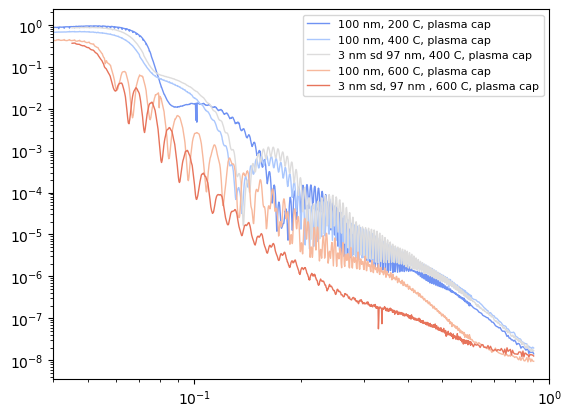

In [130]:
#Load data
import seaborn as sns 
sns.set_palette("coolwarm", 5)
data_list = ['S052_XRR01_run1_XRRstitched.csv',
             'S053_XRR02_run1_XRRstitched.csv',
             'S056_XRR05_stitched',
             'S054_XRR03_run1_XRRstitched.csv',
             'S055_XRR04_stitched']
desc = ['100 nm, 200 C, plasma cap', 
         '100 nm, 400 C, plasma cap', 
         '3 nm sd 97 nm, 400 C, plasma cap',
         '100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

for d, de in zip(data_list, desc):
    data = loadRefData(d, x_start=150)
    #plt.loglog(data.x, data.y, label=d[0:4], linewidth=1)
    plt.loglog(data.x, data.y, label=de, linewidth=1)
plt.legend(fontsize=8)
plt.xlim([0.04, 1])

# SLD dict

In [6]:
SLD_dict = {
    "si": 19.83 + 0.104j,
    "nbf": 40.83 + 0.104j,
    "sio2": 18.709 + 0.054j,
    "ta": 112.93 + 10.71j,
    "ta2o5": 59.37 + 4.42j
}

In [88]:
objective = Objective(model, data, transform=Transform("logY"))
fitter = CurveFitter(objective)
fitter.fit("differential_evolution")

0.76891051151845: : 444it [07:26,  1.01s/it]  


             message: Optimization terminated successfully.
             success: True
                 fun: 0.76891051151845
                   x: [ 1.153e+00  7.890e-09 ...  2.444e+01  8.253e+00]
                 nit: 444
                nfev: 116265
          population: [[ 1.153e+00  7.890e-09 ...  2.444e+01  8.253e+00]
                       [ 1.145e+00  9.058e-09 ...  2.333e+01  9.500e+00]
                       ...
                       [ 1.139e+00  7.682e-09 ...  2.110e+01  8.505e+00]
                       [ 1.161e+00  8.425e-09 ...  2.263e+01  8.269e+00]]
 population_energies: [ 7.689e-01  7.893e-01 ...  7.924e-01  7.928e-01]
               covar: [[ 9.054e-05  1.251e-13 ...  1.408e-02 -5.531e-04]
                       [ 1.251e-13  2.056e-19 ... -6.233e-10 -3.131e-11]
                       ...
                       [ 1.408e-02 -6.233e-10 ...  3.063e+02  1.064e+01]
                       [-5.531e-04 -3.131e-11 ...  1.064e+01  3.000e+00]]
              stderr: [ 9.515e-03  

Text(0, 0.5, 'logR')

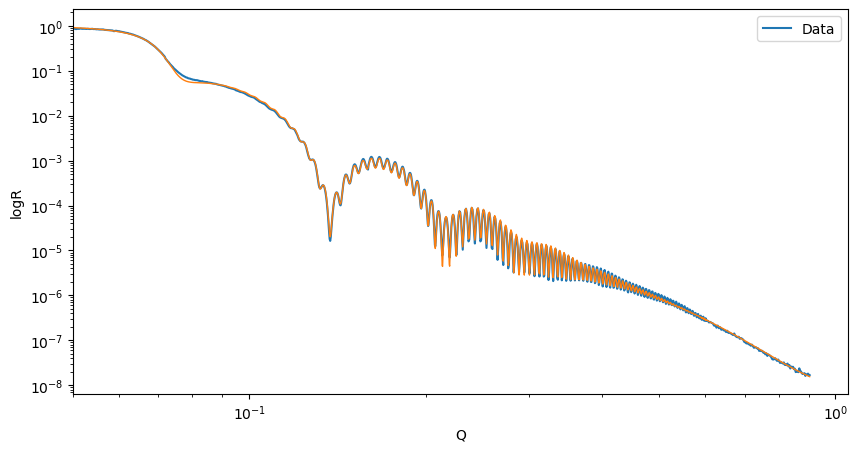

In [89]:
#objective.plot()
plt.figure(figsize=(10,5))
plt.loglog(data.x, data.y, label="Data")
plt.semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)
plt.legend()
plt.xlim(left=0.05)
plt.xlabel("Q")
plt.ylabel("logR")


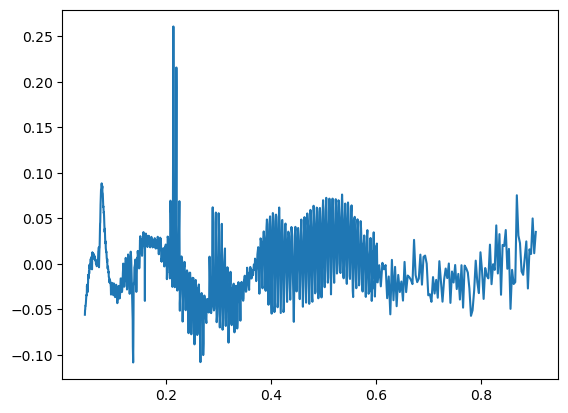

In [90]:
plt.plot(data.x, objective.residuals())

In [92]:
print(objective.parameters)#[0].parameters.data

________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.15347 +/- 0.00952, bounds=[0.45, 1.4]>
<Parameter:     'bkg'     , value=7.89015e-09 +/- 4.53e-10, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=0.549173 +/- 0.367, bounds=[0.01, 4.0]>
<Parameter:  'q_offset'   , value=-0.00115143 +/- 9.43e-05, bounds=[-0.05, 0.05]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'Air'     
<Parameter:  'Air - sld'  , value=0  (fixed) , bounds=[-inf, inf

In [95]:
a = process_objective(objective)
generate_table(a)

Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            7.59            0.83               59.9
   Ta          103.92            0.55              108.1
   Ta            2.39            0.22               53.0
 SiO2            6.28            2.44               11.6
   Si             inf            0.83               19.8

Additional Parameters:
      Parameter       Value
          Chisq  1.5380e+00
     Background  7.8900e-09
DQ - Resolution  5.4920e-01
       Q Offset -1.1510e-03


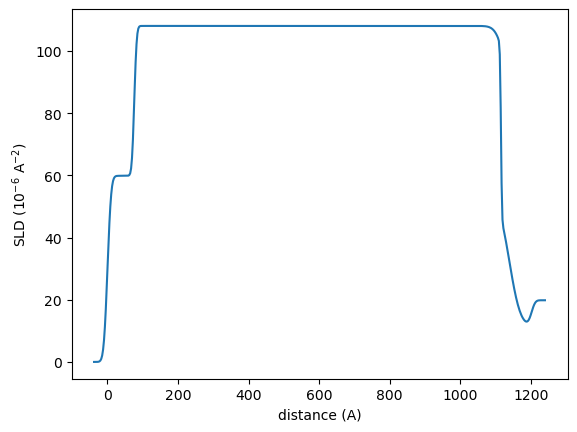

In [ ]:
fig, ax = plotOut(structure.sld_profile()[0], structure.sld_profile()[1], "distance (A)", "SLD ($10^{-6}$ A$^{-2}$)")

# Combo

In [ ]:
#Load data
import seaborn as sns 
sns.set_palette("coolwarm", 6)
data_list =['S054_XRR03_run1_XRRstitched.csv']
 #['S052_XRR01_run1_XRRstitched.csv',]
            #  'S053_XRR02_run1_XRRstitched.csv',
            #  'S056_XRR05_stitched']
            #  'S054_XRR03_run1_XRRstitched.csv',
            #  'S055_XRR04_stitched']
desc = ['100 nm, 200 C, plasma cap', 
         '100 nm, 400 C, plasma cap', 
         '3 nm sd 97 nm, 400 C, plasma cap',
         '100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


# data_list = ['S054_XRR03_run1_XRRstitched.csv',
#             'S055_XRR04_stitched']
# desc = ['100 nm, 600 C, plasma cap', 
#          '3 nm sd, 97 nm , 600 C, plasma cap', ]
coef = [1.4, 1.5]

for j in range(len(coef)):
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    ax = ax.flatten()
    for i, d in enumerate(data_list):
        #data = loadRefData(d, x_start=150)
        
        full_path = os.path.join('..','Data', d)
        data = ana_xrr.loadRefData(full_path)
        x_err = ana_xrr.standalone_xerr(data.x)
        data = ana_xrr.loadRefData(full_path, qrng=[0.04, 1], coef=coef[j], x_err=x_err)
        
        air_layer = SLD(0, name='Air')(0, 0)
        ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(400,15)
        ta_layer = SLD(SLD_dict['ta'], name='Ta')(700, 2)
        ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(500, 5)
        m_layer = SLD(SLD_dict['ta'], name='TaSi')(40, 10)
        sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(20, 4)
        b_layer = SLD(10, name='SiO2')(20, 4)

        si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)

        ta2o5_layer.rough.setp(bounds = (0,35), vary = True)
        ta2o5_layer.thick.setp(bounds = (5, 500), vary = True)
        ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)
        
        ta_layer.rough.setp(bounds = (0,30), vary = True)
        ta_layer.thick.setp(bounds = (400, 1300), vary = True)
        ta_layer.sld.real.setp(bounds = (80,120), vary = True)

        ta2_layer.rough.setp(bounds = (0,30), vary = True)
        ta2_layer.thick.setp(bounds = (500, 1000), vary = True)
        ta2_layer.sld.real.setp(bounds = (80,115), vary = True)


        m_layer.rough.setp(bounds = (0,35), vary = True)
        m_layer.thick.setp(bounds = (20, 130), vary = True)
        m_layer.sld.real.setp(bounds = (20,100), vary = True)

        sio2_layer.rough.setp(bounds = (0,35), vary = True)
        sio2_layer.thick.setp(bounds = (0, 100), vary = True)
        sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

        b_layer.rough.setp(bounds = (0,35), vary = True)
        b_layer.thick.setp(bounds = (0, 100), vary = True)
        b_layer.sld.real.setp(bounds = (5,25), vary = True)
        
        si_layer.rough.setp(bounds = (0, 25), vary = True)
        
        #structure = air_layer | ta_layer | si_layer
        
        structure = air_layer | ta2o5_layer | ta_layer | m_layer | sio2_layer | si_layer
        #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

        model = ReflectModel(structure, bkg=1.3e-8, dq=1, scale=0.5, q_offset=0.0, dq_type='pointwise')
        model.scale.setp(bounds=(0.45, 1), vary=True)
        model.bkg.setp(bounds=(1e-9, 5e-8), vary=True)
        model.dq.setp(bounds=(0.01,4), vary=False)
        model.q_offset.setp(bounds=(-0.02,0.02), vary=True)

        objective = Objective(model, data, transform=Transform("logY"))
        fitter = CurveFitter(objective)
        fitter.fit("differential_evolution")

        #objective.plot()
        
        ax[0].loglog(data.x, data.y, label=desc[i])
        ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)

        ax[1].semilogx(data.x, objective.residuals())
        a = process_objective(objective)
        generate_table(a)


        ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

    ax[2].set_xlabel("distance (A)")
    ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

    ax[0].legend(fontsize=8)
    ax[0].set_xlim(left=0.04)
    ax[0].set_xlabel("Q")
    ax[0].set_ylabel("logR")

c:\_Lib\xrr_analysis\ana_xrr.py:172: RuntimeWarning: divide by zero encountered in divide
  cot = 1 / np.tan(theta_radians)


Error at 0.665996094  is 1.0753291110124201 %
Error at 6.0  is 0.1189295556777823 %


13.996843940003155: : 150it [08:45,  3.73s/it]

# Set up program

0.20174828654505378: : 1026it [07:34,  2.26it/s]
c:\_Lib\xrr_analysis\ana_xrr.py:775: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


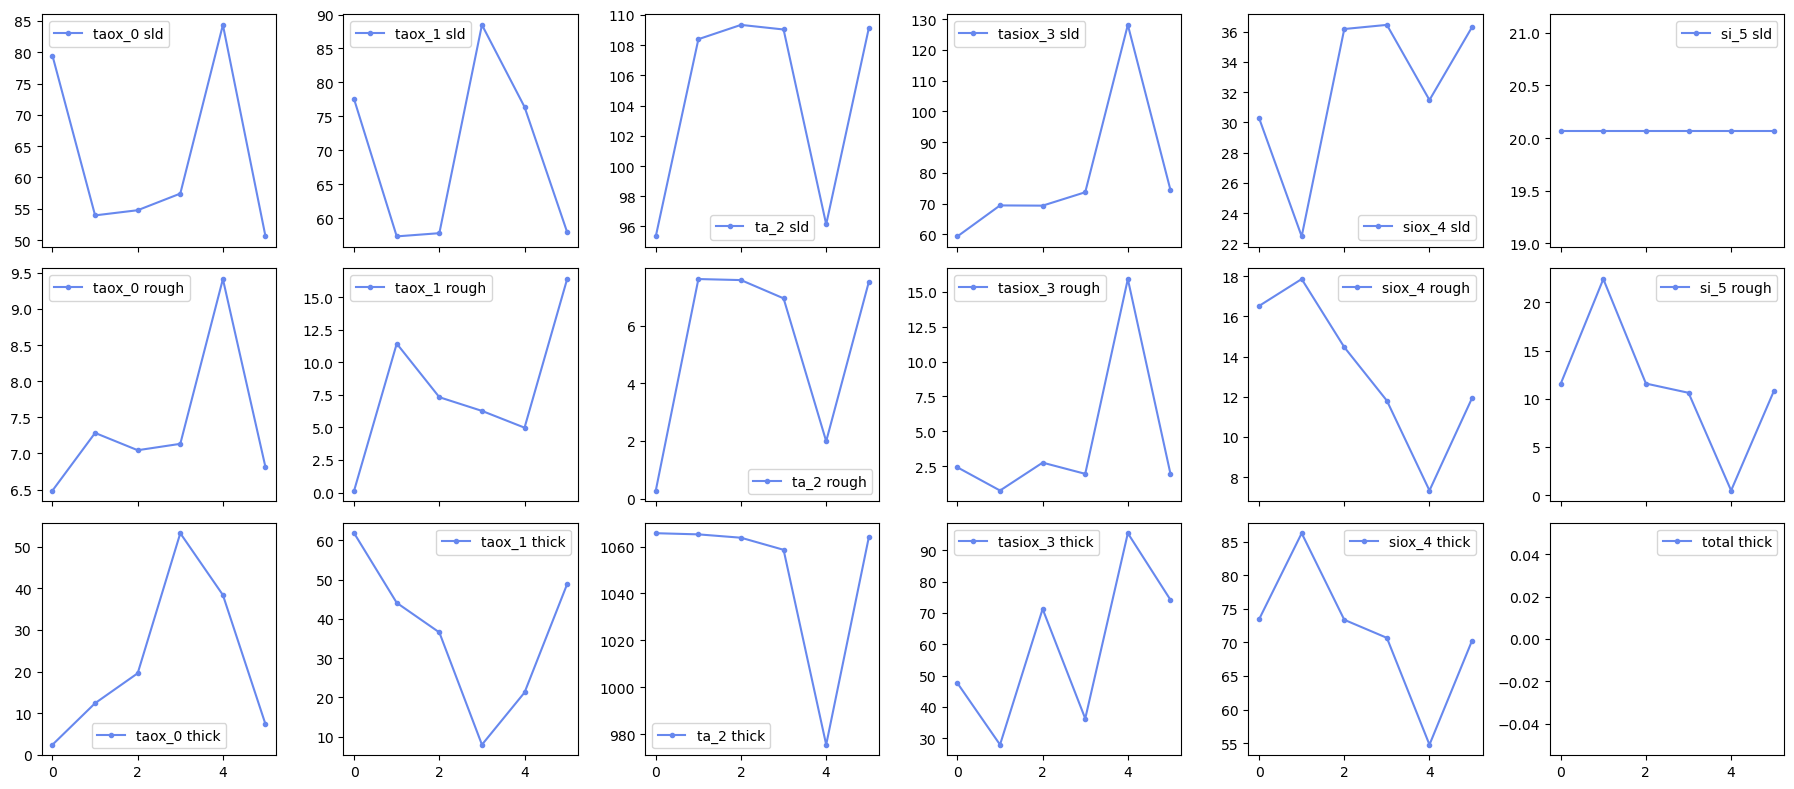

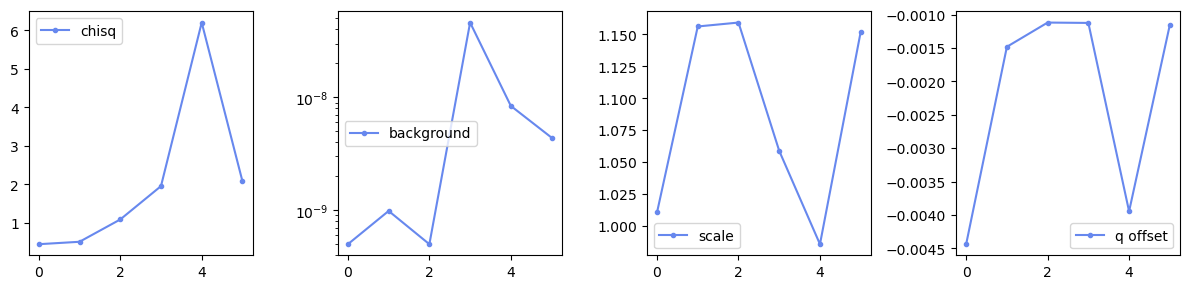

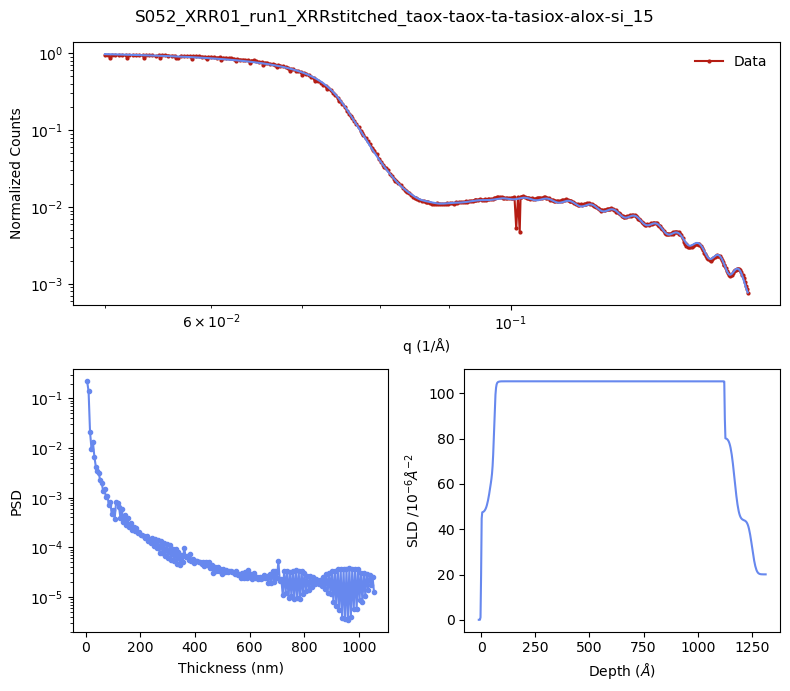

1.0358789943426463: : 203it [02:00,  1.68it/s]


KeyboardInterrupt: 

In [85]:

# out_lists has length layers, and is a list with different qrngs
%matplotlib inline
par={'scale':0.5, 'bkg':1e-8, 'q_offset':0, 'dq - resolution':0.5, 'sub_rough_max':25, 'x_err':1.5}
qrng = [0.05, 0.15]
layers = ['taox/taox/ta/tasiox/alox']#,'taox/taox/ta/taox/sio2'] 

data_list =['S052_XRR01_run1_XRRstitched.csv',]
# ['S054_XRR03_run1_XRRstitched.csv']
            #  'S053_XRR02_run1_XRRstitched.csv',
            #  'S056_XRR05_stitched']
            #  'S054_XRR03_run1_XRRstitched.csv',
            #  'S055_XRR04_stitched']
desc = ['100 nm, 200 C, plasma cap', 
         '100 nm, 400 C, plasma cap', 
         '3 nm sd 97 nm, 400 C, plasma cap',
         '100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

out_lists =[[] for _ in range(len(layers))]
SLD_rng = [0.65, 0.1]
for i in range(len(layers)): 
    
    layers[i]=layers[i]+ '/si'
full_path = os.path.join('..','Data', data_list[0])

par['thk'] = [1000]
for i in range(6):
    qrng[1]=0.15 + 0.05*i+0.025*i**2
    for j in range(len(layers)):
        out_lists[j].append(ana_xrr.sim(full_path, layers[j], par, qrng, SLD_rng=SLD_rng, use_err=False, img_path='../Outputs/'))

full_obj = ana_xrr.collect_obj(out_lists)
full_pars = ana_xrr.collect_pars(out_lists)


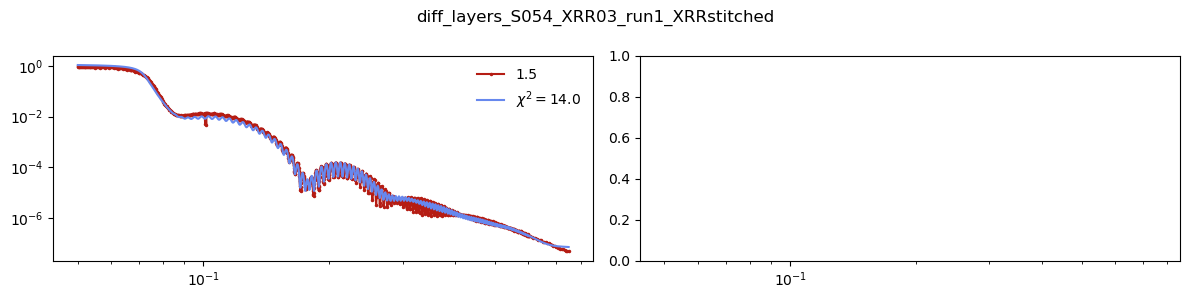

In [79]:
layer_list = [layer.replace('/', '-') for layer in layers]
layer_list = np.linspace(1.5,2.5,6)
plot_ind = 0 
q_ind = 4
# outer is layers, inner is q range  

def grab_ind(obj_list, ind): 
    return [o[ind] for o in obj_list]

ana_xrr.plot_obj_pane(grab_ind(full_obj,q_ind), layer_list, ind=plot_ind, path='..', fname='diff_layers_'+d[0:-4])

1


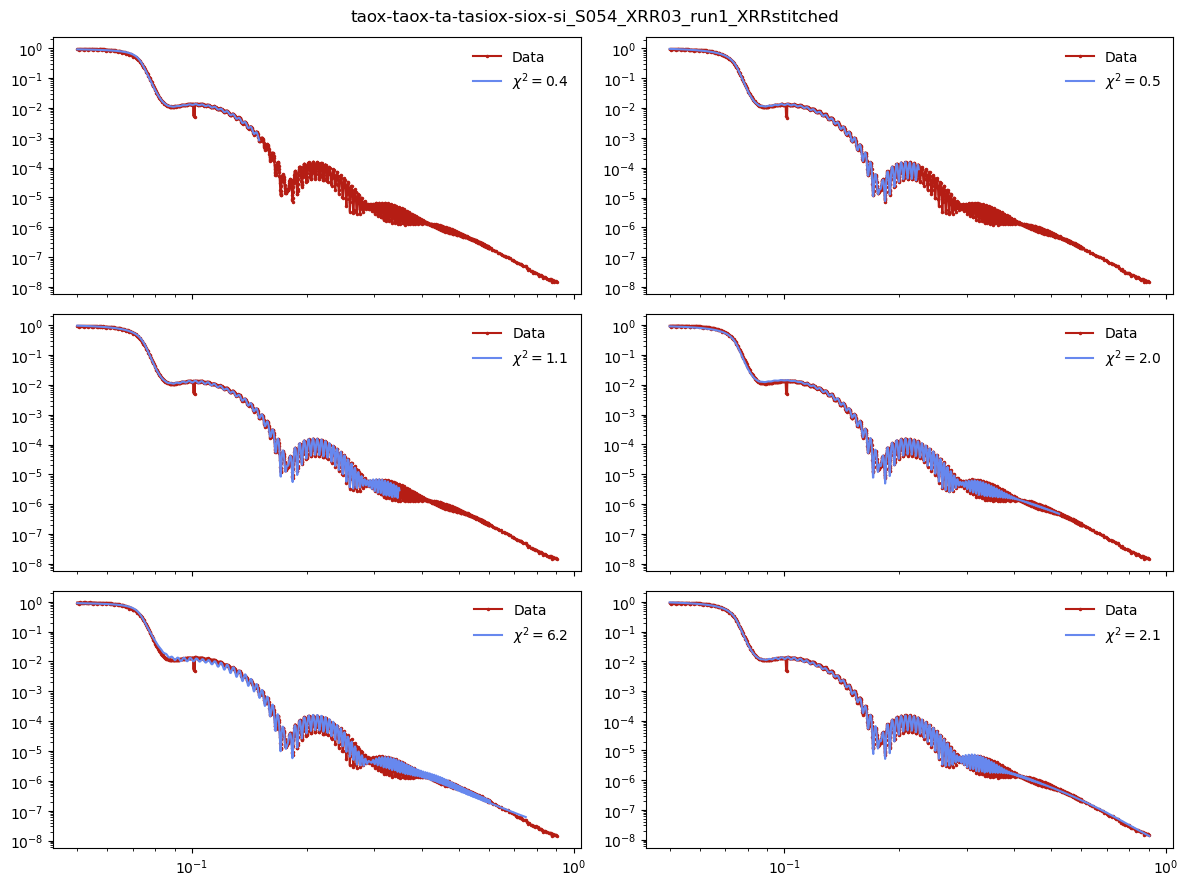

In [84]:
# This chooses one layer and plots all the different leghts 
print(len(full_obj))
layer_ind =0
name_ind=0
ana_xrr.plot_obj_pane(full_obj[layer_ind], ['Data']*len(full_obj[layer_ind]), ind=len(full_obj[layer_ind])-1, path='..', fname=layers[name_ind].replace('/', '-')+'_'+d[0:-4])
ana_xrr.compare_pars(full_pars[layer_ind], img_path='..', fname=layers[name_ind].replace('/', '-')+'_'+d[0:-4])

In [81]:
%matplotlib inline
ana_xrr.compare_pars(full_pars[0], img_path='..', fname=layers[name_ind].replace('/', '-')+'_'+d[0:-4])

In [71]:
ana_xrr.compare_models(full_pars[0])

{'sld': {np.str_('taox_0'): [np.float64(77.24321307710731),
   np.float64(54.261258847058585),
   np.float64(56.9792933321418),
   np.float64(56.42501697638029),
   np.float64(55.42287462083082),
   np.float64(55.81030256328865)],
  np.str_('ta_1'): [np.float64(95.0449083066175),
   np.float64(103.80204256954985),
   np.float64(109.07402697204397),
   np.float64(108.88145930342601),
   np.float64(108.14726733717596),
   np.float64(108.31988001643705)],
  np.str_('tasiox_2'): [np.float64(77.9386903149195),
   np.float64(56.60099255786162),
   np.float64(67.4054750532449),
   np.float64(73.01273836055603),
   np.float64(72.40478378294495),
   np.float64(72.71614082758883)],
  np.str_('siox_3'): [np.float64(31.438628127880857),
   np.float64(14.439451954350623),
   np.float64(36.00644958227266),
   np.float64(37.17363961557201),
   np.float64(32.35509409977358),
   np.float64(37.41850408875518)],
  np.str_('si_4'): [np.float64(20.071),
   np.float64(20.071),
   np.float64(20.071),
   np.f

In [67]:
# This chooses one layer and plots all the different leghts 
print(len(full_obj))
layer_ind =5
name_ind=0
ana_xrr.plot_obj_pane(full_obj[layer_ind], ['Data']*len(full_obj[layer_ind]), ind=len(full_obj[layer_ind])-1, path=img_pth, fname=layers[name_ind].replace('/', '-')+'_'+data_file[0:-4])
ana_xrr.compare_pars(full_pars[layer_ind], img_path=img_pth, fname=layers[name_ind].replace('/', '-')+'_'+data_file[0:-4])

1


IndexError: list index out of range

In [70]:
full_pars[-1][-1]

{'thk': array([  56.21944702, 1064.63021635,   35.25643043,   71.37623179,
                  inf]),
 'rough': array([ 7.13851266,  7.48687284,  1.95810733, 11.90617722, 10.73464276]),
 'sld': array([ 55.81030256, 108.31988002,  72.71614083,  37.41850409,
         20.071     ]),
 'layers': array(['taox_0', 'ta_1', 'tasiox_2', 'siox_3', 'si_4'], dtype='<U8'),
 'scale': np.float64(1.0927791055601461),
 'bkg': np.float64(2.9919086795511062e-09),
 'dq - resolution': np.float64(0.5668669290620221),
 'q_offset': np.float64(-0.0013640044426012322),
 'chisq': np.float64(2.398233901362885),
 'sub_rough_max': 25}

In [37]:
a = process_objective(obj)
generate_table(a)

Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
taox_0            5.73            0.80               54.2
  ta_1          104.66            0.64              102.5
taox_2            2.88            1.78               60.3
sio2_3            1.00            0.10               22.7
  si_4             inf            0.60               20.1

Additional Parameters:
      Parameter       Value
          Chisq  4.6660e-01
     Background  5.0000e-10
DQ - Resolution  1.5660e-01
       Q Offset -3.8100e-03


In [35]:
print(obj)

________________________________________________________________________________
Objective - 2199066697040
Dataset = <None>, 399 points
datapoints = 399
chi2 = 11.14198968522205
Weighted = False
Transform = Transform('logY')
________________________________________________________________________________
________________________________________________________________________________
<Parameter:    'scale'    , value=1.1 +/- 0.398, bounds=[0.4, 1.1]>
<Parameter:     'bkg'     , value=5e-10 +/- 0.013, bounds=[5e-10, 5e-08]>
<Parameter:'dq - resolution', value=0.449331 +/- 0.19 , bounds=[0.001, 2.2]>
<Parameter:  'q_offset'   , value=0.00508901 +/- 0.0194, bounds=[-0.02, 0.02]>
________________________________________________________________________________
________________________________________________________________________________
<Parameter: 'air - thick' , value=inf  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
<Pa

In [ ]:

def run_simulation(i, j, k, layers, flist, qrng, SLD_rng):
    qrng[1] = 0.15 + 0.05 * i + 0.025 * i ** 2
    par = {'scale': 1, 'bkg': 5e-9, 'q_offset': 0, 'dq - resolution': 0.5, 'sub_rough_max': 20, 'x_err': 1.9}
    par['thk'] = [60, 570]
    return ana_xrr.sim(pth + flist[k], layers[j], par, qrng, SLD_rng=SLD_rng, img_path='../Outputs/')

results = Parallel(n_jobs=-1)(delayed(run_simulation)(i, j, k, layers, f, qrng.copy(), SLD_rng) for k in range(len(f)) for i in tqdm(range(7), desc="Outer Loop") for j in tqdm(range(len(layers)), desc="Inner Loop", leave=False))

#results = Parallel(n_jobs=-1)(delayed(run_simulation)(i, j, layers, data_file, qrng.copy(), SLD_rng) for i in range(6) for j in range(len(layers)))


In [40]:
objective.__dir__()

['model',
 'data',
 'lnsigma',
 'auxiliary_params',
 '_use_weights',
 'transform',
 'logp_extra',
 'name',
 'alpha',
 '__module__',
 '__doc__',
 '__init__',
 '__str__',
 '__repr__',
 'weighted',
 'npoints',
 'varying_parameters',
 '_data_transform',
 'generative',
 'residuals',
 'chisqr',
 'parameters',
 'setp',
 'prior_transform',
 'logp',
 'logl',
 'nll',
 'logpost',
 'covar',
 '_covar_from_residuals',
 'pgen',
 '_generate_generative_mcmc',
 'plot',
 'corner',
 'nlpost',
 '__dict__',
 '__weakref__',
 '__new__',
 '__hash__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [46]:
objective.model

ReflectModel(Structure(components=[Slab(Parameter(value=0.0, name='Air - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), SLD([Parameter(value=0.0, name='Air - sld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='Air - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='Air'), Parameter(value=0.0, name='Air - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='Air', vfsolv=Parameter(value=0.0, name='Air - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), Slab(Parameter(value=55.289342339249565, name='Ta205 - thick', vary=True, bounds=Interval(lb=5.0, ub=100.0), constraint=None), SLD([Parameter(value=41.233532758508105, name='Ta205 - sld', vary=True, bounds=Interval(lb=40.0, ub=80.0), constraint=None), Parameter(value=4.42, name='Ta205 - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), con

In [45]:
objective.varying_parameters

<bound method Objective.varying_parameters of Objective(ReflectModel(Structure(components=[Slab(Parameter(value=0.0, name='Air - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), SLD([Parameter(value=0.0, name='Air - sld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='Air - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='Air'), Parameter(value=0.0, name='Air - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='Air', vfsolv=Parameter(value=0.0, name='Air - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), Slab(Parameter(value=55.289342339249565, name='Ta205 - thick', vary=True, bounds=Interval(lb=5.0, ub=100.0), constraint=None), SLD([Parameter(value=41.233532758508105, name='Ta205 - sld', vary=True, bounds=Interval(lb=40.0, ub=80.0), constraint=None), Parameter(value=4.42, name='Ta205 - isld',

In [41]:
objective._use_weights

True

In [44]:
objective.weighted

True

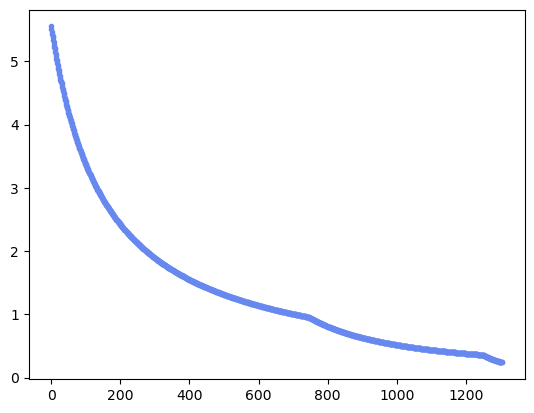

In [31]:
plt.plot(x_err[150:], '.-')

16.755173560266172: : 184it [03:13,  1.05s/it]




Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            0.51            1.72               69.8
   Ta           43.61            0.23               83.4
 TaSi            2.47            0.97               20.7
 SiO2            3.01            1.35               21.8
   Si             inf            0.50               19.8

Additional Parameters:
      Parameter      Value
          Chisq 3.3510e+01
     Background 8.3220e-09
DQ - Resolution 6.5910e-01
       Q Offset 1.0710e-02


12.586852208393802: : 354it [06:00,  1.02s/it]





Layer Properties:
Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
Ta205            1.36            2.02               78.0
   Ta          128.26            0.40               80.4
 TaSi           29.24            2.36               46.2
 SiO2            1.17            0.43               33.2
   Si             inf            0.16               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.5160e+01
     Background 1.1730e-08
DQ - Resolution 7.9760e-01
       Q Offset 1.1370e-02


Text(0, 0.5, 'logR')

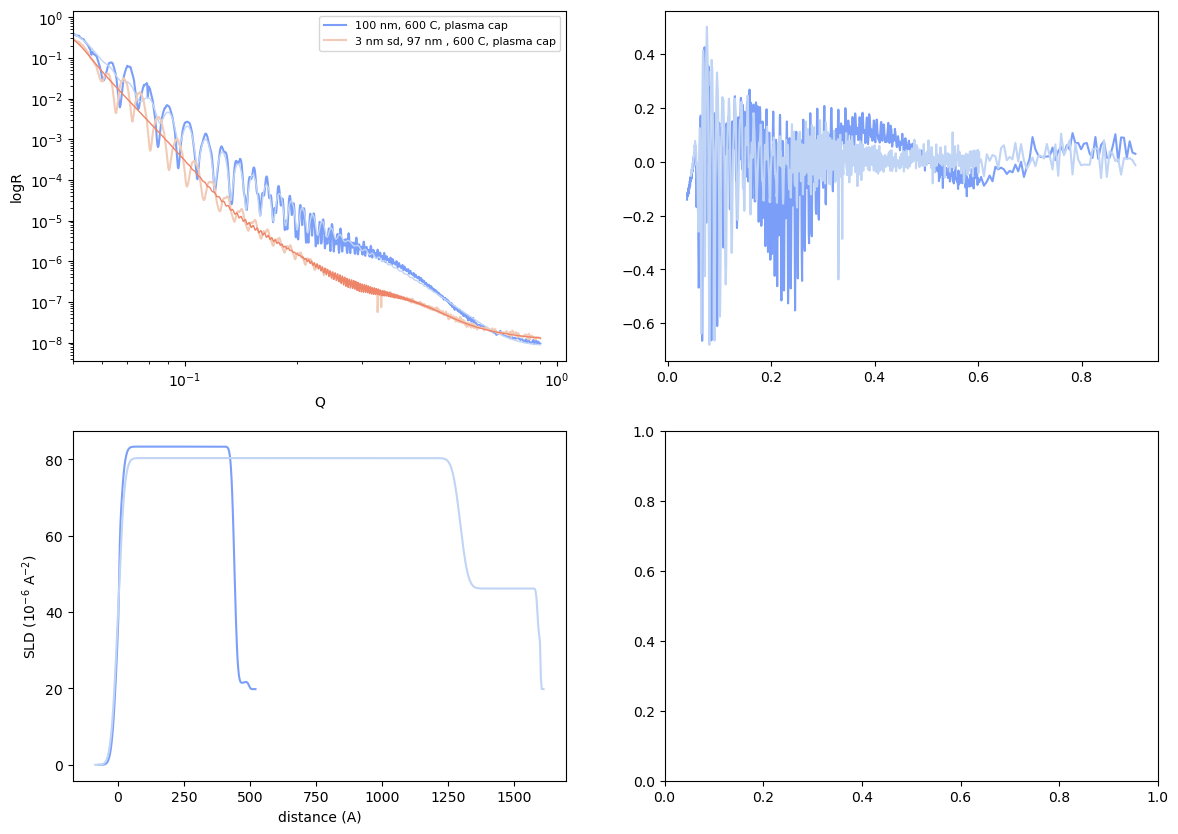

In [143]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv',
            'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

fig, ax = plt.subplots(2, 2, figsize=(14,10))
ax = ax.flatten()
for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(50, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(500, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(50, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(100, 3)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(77,9)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (400, 1300), vary = True)
    ta_layer.sld.real.setp(bounds = (80,120), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (400, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (80,130), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.3,0.8), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    q = np.linspace(0.01, 0.9, 10001)
    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
    ax[0].loglog(data.x, data.y, label=desc[i])
    ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)

    ax[1].plot(data.x, objective.residuals())
    a = process_objective(objective)
    generate_table(a)

    ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.05)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

7.19564242945082: : 776it [16:37,  1.29s/it]  




Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            0.63            1.51               74.3
    Ta           44.03            0.21               80.1
Ta_bot           87.41            0.87              129.9
  TaSi            3.79            1.17               63.9
  SiO2            2.17            0.37               11.1
    Si             inf            0.42               19.8

Additional Parameters:
      Parameter      Value
          Chisq 1.4390e+01
     Background 1.0330e-08
DQ - Resolution 7.9990e-01
       Q Offset 1.4710e-02


12.251885338928087: : 574it [12:04,  1.26s/it]





Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            1.69            1.94               78.5
    Ta          129.02            0.62               86.9
Ta_bot           98.97            0.82               89.4
  TaSi           28.32            1.22               96.9
  SiO2            2.44            0.29               41.9
    Si             inf            0.85               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.4490e+01
     Background 1.3610e-08
DQ - Resolution 7.9400e-01
       Q Offset 1.4360e-02


Text(0, 0.5, 'logR')

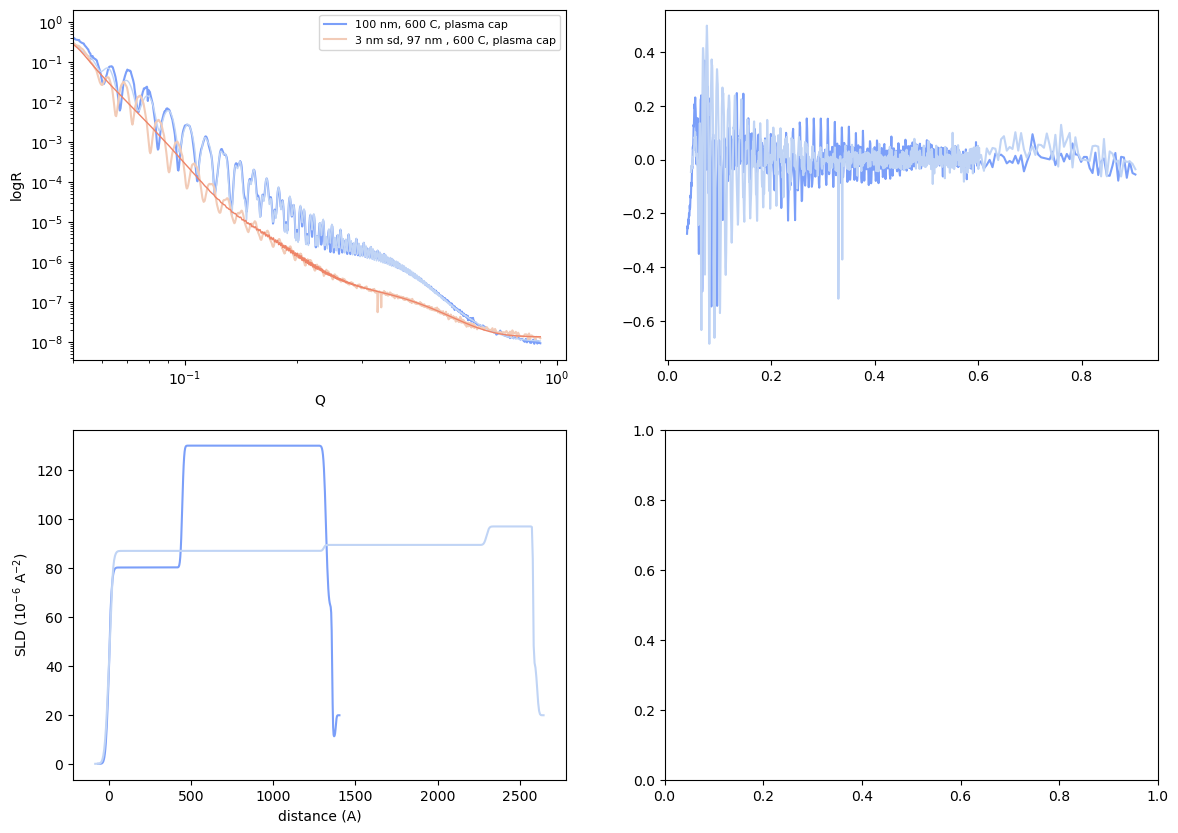

In [144]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv',
            'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]

fig, ax = plt.subplots(2, 2, figsize=(14,10))
ax = ax.flatten()
for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(50, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(500, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(500, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(100, 3)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(77,9)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (80,120), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (80,130), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.3,0.8), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    q = np.linspace(0.01, 0.9, 10001)
    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
    ax[0].loglog(data.x, data.y, label=desc[i])
    ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=1)

    ax[1].plot(data.x, objective.residuals())
    a = process_objective(objective)
    generate_table(a)

    ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.05)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

0it [00:00, ?it/s]

11.197161166366834: : 447it [10:37,  1.43s/it]




Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            0.53            1.62               55.7
    Ta           43.40            0.22               70.1
Ta_bot           86.46            1.00              128.7
  TaSi            4.56            1.14               70.3
  SiO2            3.22            0.39               25.7
    Si             inf            0.38               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.2390e+01
     Background 8.3320e-09
DQ - Resolution 6.1960e-01
       Q Offset 2.7220e-03


Text(0, 0.5, 'logR')

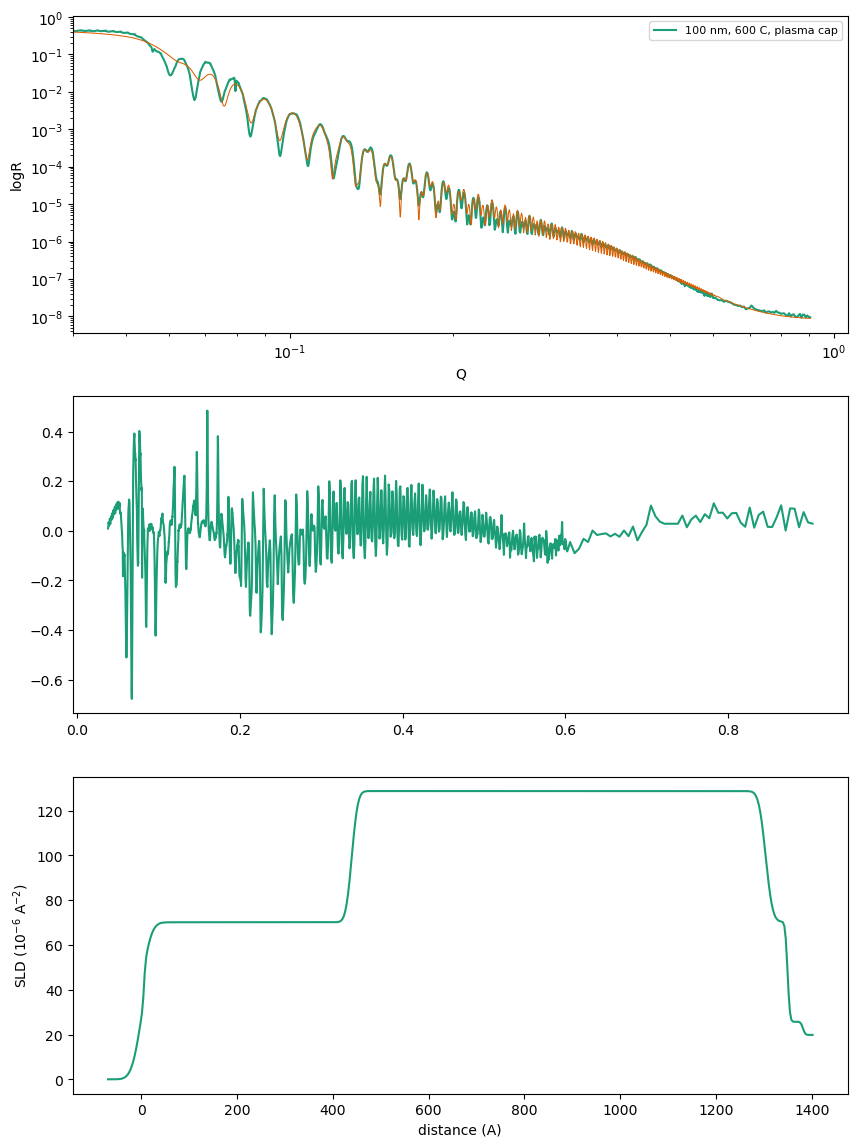

In [154]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv']
           # 'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(10, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(300, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(750, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(20, 12)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(20,12)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (70,110), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (90,140), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.375,0.62), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
sns.set_palette("Dark2")

fig, ax = plt.subplots(3, 1, figsize=(10,14))
ax = ax.flatten()
ax[0].loglog(data.x, data.y, label=desc[i])
ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=0.75)

ax[1].plot(data.x, objective.residuals())
a = process_objective(objective)
generate_table(a)

ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.04)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

13.263617143950338: : 456it [10:34,  1.39s/it]





Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            0.52            1.63               75.1
    Ta           43.86            0.23               85.1
Ta_bot           65.58            0.88              124.9
  TaSi           19.94            1.85               56.6
  SiO2            6.61            1.71               44.5
    Si             inf            0.37               19.8

Additional Parameters:
      Parameter      Value
          Chisq 2.6490e+01
     Background 9.4810e-09
DQ - Resolution 6.1150e-01
       Q Offset 1.6430e-02


Text(0, 0.5, 'logR')

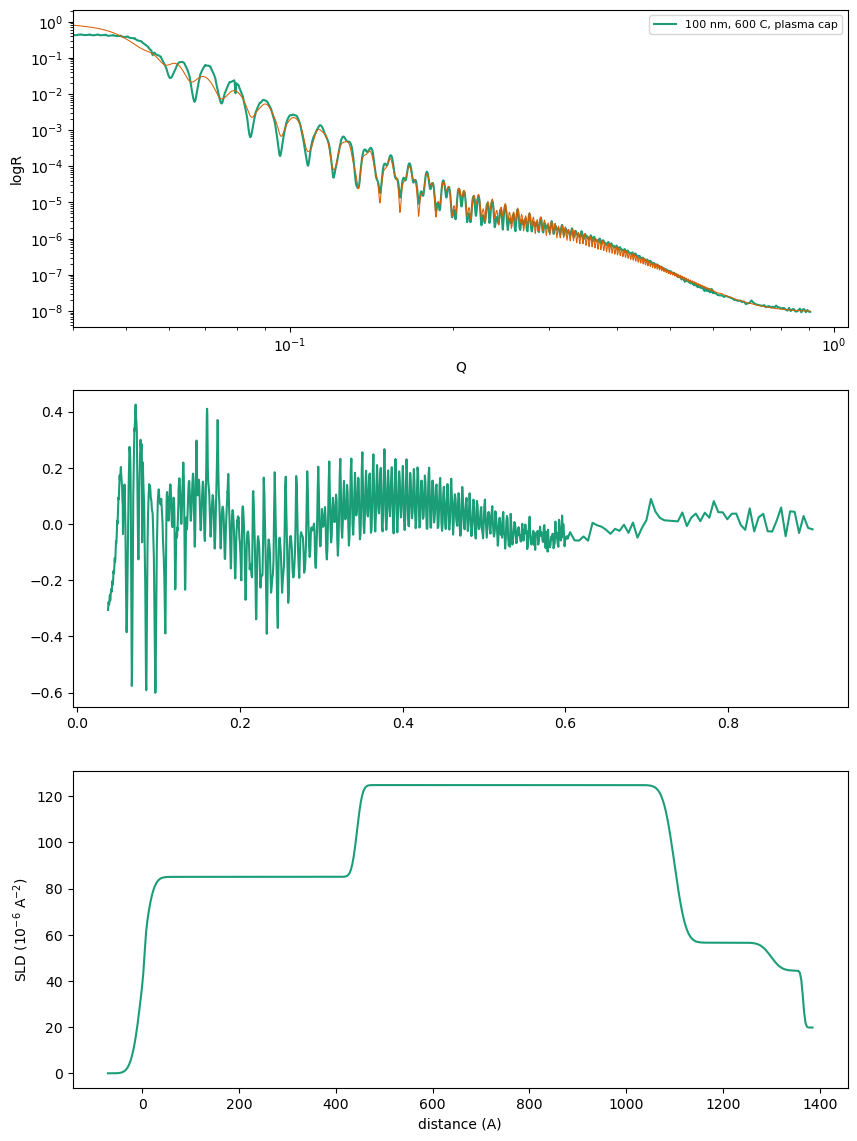

In [155]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv']
           # 'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(10, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(300, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_bot')(750, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(20, 12)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(20,12)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (85,110), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (90,125), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.375,0.62), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
sns.set_palette("Dark2")

fig, ax = plt.subplots(3, 1, figsize=(10,14))
ax = ax.flatten()
ax[0].loglog(data.x, data.y, label=desc[i])
ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=0.75)

ax[1].plot(data.x, objective.residuals())
a = process_objective(objective)
generate_table(a)

ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.04)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")

In [ ]:
#Load data
sns.set_palette("coolwarm", 4)

data_list = ['S054_XRR03_run1_XRRstitched.csv']
           # 'S055_XRR04_stitched']
desc = ['100 nm, 600 C, plasma cap', 
         '3 nm sd, 97 nm , 600 C, plasma cap', ]


for i, d in enumerate(data_list):
    data = loadRefData(d, x_start=150)

    si_layer = SLD(SLD_dict['si'], name='Si')(np.inf, 3.5)
    sio2_layer = SLD(SLD_dict['sio2'], name='SiO2')(10, 5)
    ta_layer = SLD(SLD_dict['ta'], name='Ta')(300, 2)
    ta2_layer = SLD(SLD_dict['ta'], name='Ta_mid')(750, 5)
    m_layer = SLD(SLD_dict['ta'], name='TaSi')(20, 12)
    ta2o5_layer = SLD(SLD_dict['ta2o5'], name='Ta205')(20,12)
    air_layer = SLD(0, name='Air')(0, 0)

    si_layer.rough.setp(bounds = (0, 10), vary = True)

    ta_layer.rough.setp(bounds = (0,10), vary = True)
    ta_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta_layer.sld.real.setp(bounds = (70,110), vary = True)

    ta2_layer.rough.setp(bounds = (0,10), vary = True)
    ta2_layer.thick.setp(bounds = (200, 1000), vary = True)
    ta2_layer.sld.real.setp(bounds = (90,140), vary = True)

    ta2o5_layer.rough.setp(bounds = (0,25), vary = True)
    ta2o5_layer.thick.setp(bounds = (5, 100), vary = True)
    ta2o5_layer.sld.real.setp(bounds = (40,80), vary = True)

    sio2_layer.rough.setp(bounds = (0,25), vary = True)
    sio2_layer.thick.setp(bounds = (0, 100), vary = True)
    sio2_layer.sld.real.setp(bounds = (10,45), vary = True)

    m_layer.rough.setp(bounds = (0,25), vary = True)
    m_layer.thick.setp(bounds = (20, 300), vary = True)
    m_layer.sld.real.setp(bounds = (20,100), vary = True)
    #structure = air_layer | ta_layer | si_layer

    
    structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer
    #structure = air_layer | ta2o5_layer | ta_layer | ta2_layer | m_layer | sio2_layer | si_layer

    model = ReflectModel(structure, bkg=1.3e-8, dq=0.5, scale=0.5, q_offset=0.0)
    model.scale.setp(bounds=(0.45, 1.4), vary=True)
    model.bkg.setp(bounds=(1e-9, 1e-7), vary=True)
    model.dq.setp(bounds=(0.375,0.62), vary=True)
    model.q_offset.setp(bounds=(-0.05,0.05), vary=True)

    q = np.linspace(0.01, 0.9, 10001)
    objective = Objective(model, data, transform=Transform("logY"))
    fitter = CurveFitter(objective)
    fitter.fit("differential_evolution")

    #objective.plot()
    
sns.set_palette("Dark2")

fig, ax = plt.subplots(3, 1, figsize=(10,14))
ax = ax.flatten()
ax[0].loglog(data.x, data.y, label=desc[i])
ax[0].semilogy(objective.data.x, objective.model(objective.data.x), linewidth=0.75)

ax[1].plot(data.x, objective.residuals())
a = process_objective(objective)
generate_table(a)

ax[2].plot(structure.sld_profile()[0], structure.sld_profile()[1])

ax[2].set_xlabel("distance (A)")
ax[2].set_ylabel("SLD ($10^{-6}$ A$^{-2}$)")

ax[0].legend(fontsize=8)
ax[0].set_xlim(left=0.04)
ax[0].set_xlabel("Q")
ax[0].set_ylabel("logR")



Layer Properties:
 Layer  Thickness (nm)  Roughness (nm)  SLD (10^-6 cm^-2)
 Ta205            1.67            1.51               46.4
    Ta           44.54            0.81               80.1
Ta_bot           73.54            0.86              130.0
  TaSi           17.65            1.53               93.4
  SiO2            3.73            0.33               40.0
    Si             inf            0.83               19.8

Additional Parameters:
      Parameter      Value
          Chisq 1.2710e+01
     Background 1.0840e-08
DQ - Resolution 6.2410e-01
       Q Offset 1.4130e-02


Text(0, 0.5, 'logR')

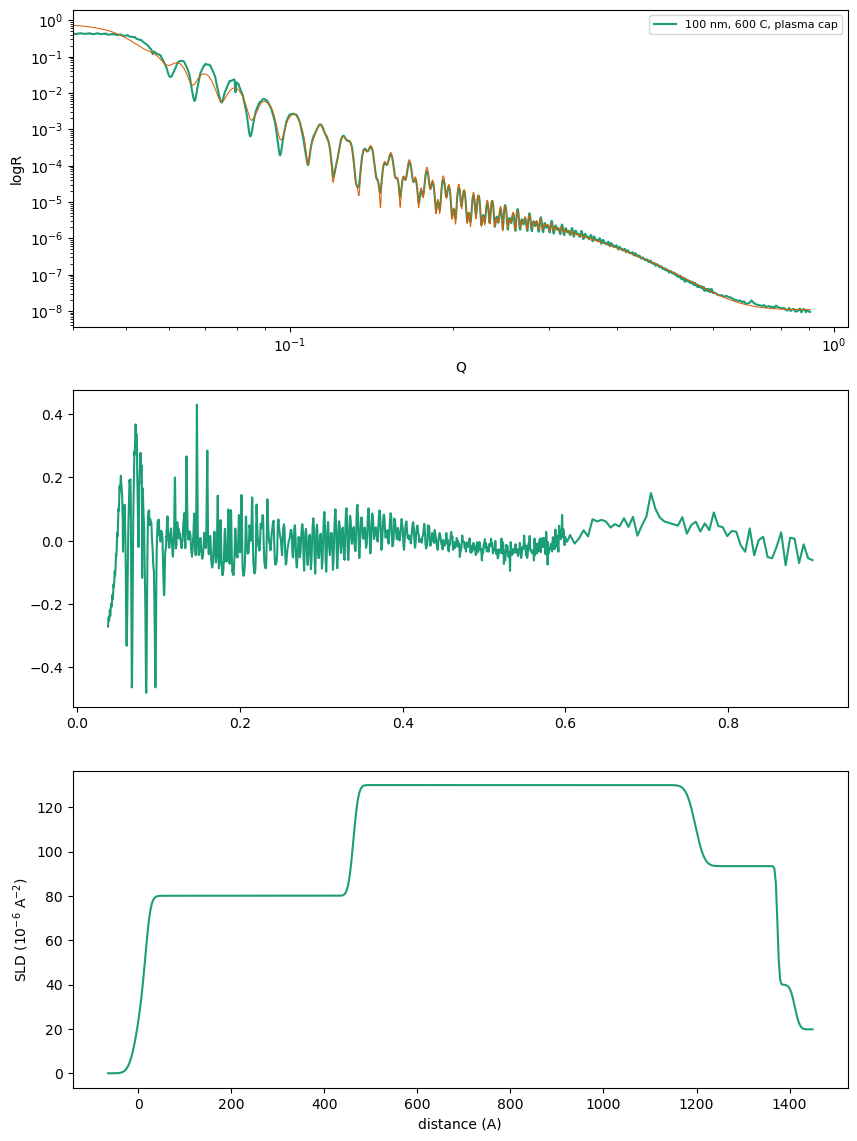

In [137]:
print(objective.parameters)#[0].parameters.data


________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.00484 +/- 0.0129, bounds=[0.45, 1.4]>
<Parameter:     'bkg'     , value=9.89197e-09 +/- 6.84e-10, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=0.571294 +/- 0.679, bounds=[0.01, 4.0]>
<Parameter:  'q_offset'   , value=-0.0088122 +/- 0.00015, bounds=[-0.05, 0.05]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'Air'     
<Parameter:  'Air - sld'  , value=0  (fixed) , bounds=[-inf, inf]>
